TODO:
* Blurb on Doc2Vec approach
* Conclusions drawn from visualizations
* Better description of topic embedding
* (clean up?) and save figures
* Describe what the topic by class, by cluster and by tree visualizations mean

# Comparing Topic Embeddings

The goal of this notebook is to use the tools in the [Tutte Institute ``vectorizers`` library](https://github.com/TutteInstitute/vectorizers) to construct topic embeddings, and to compare those embeddings with results from other popular techniques. We will compare embeddings obtained by the following techniques:
* Universal Sentence Encoder (USE) from Google
* Doc2Vec
* Wasserstein Embedding (vectorizers library)
* Approximate Wasserstein Embedding (vectorizers library)

We will compare these techniques qualitatively using various visualization techniques.

At this point ``vectorizers`` is still a research project, so this is not meant to be a rigorous comparison but rather a demonstration of general relative performance, and to show off the potential for non-neural net based approaches.

### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.preprocessing
import scipy.sparse
import vectorizers
import vectorizers.transformers
import umap
import umap.plot
import pynndescent
import seaborn as sns
import matplotlib.colors
from matplotlib.colors import rgb2hex
import hdbscan
import warnings
import tensorflow_hub as hub

warnings.simplefilter("ignore")
sns.set()

In [2]:
from src import paths
from src.data import Dataset
from src.user.viz import topic_word_by_class, topic_word_by_cluster, topic_word_tree

In [3]:
# restrict logging
import logging
logging.getLogger().setLevel(logging.WARNING)

We will need some data to work with. For the purposes of this demo we will make use of the 20 newsgroups dataset. Even though 20 newsgroups is a toy dataset, it offers enough complications to show how we can piece together document embeddings using ``vectorizers``. We've cleaned it up a little and created a custom color paletted as in `00-20-newsgroups-setup.ipynb`.

In [4]:
ds = Dataset.load('20_newsgroups_pruned')

In [5]:
print(ds.DESCR)


The 20 Newsgroups dataset is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups.

The data is organized into 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are highly unrelated (e.g misc.forsale / soc.religion.christian).

Here are the categories:

 * `alt.atheism`,
 * `comp.graphics`,
 * `comp.os.ms-windows.misc`,
 * `comp.sys.ibm.pc.hardware`,
 * `comp.sys.mac.hardware`,
 * `comp.windows.x`,
 * `misc.forsale`,
 * `rec.autos`,
 * `rec.motorcycles`,
 * `rec.sport.baseball`,
 * `rec.sport.hockey`,
 * `sci.crypt`,
 * `sci.electronics`,
 * `sci.med`,
 * `sci.space`,
 * `soc.religion.christian`,
 * `talk.politics.guns`,
 * `talk.politics.mideast`,
 * `talk.politics.misc`,
 * `talk.religion.misc`

The current version is obtained by wrapping `sklearn.datasets.fetch_20newsgroups

## Vectorizers-based Embeddings
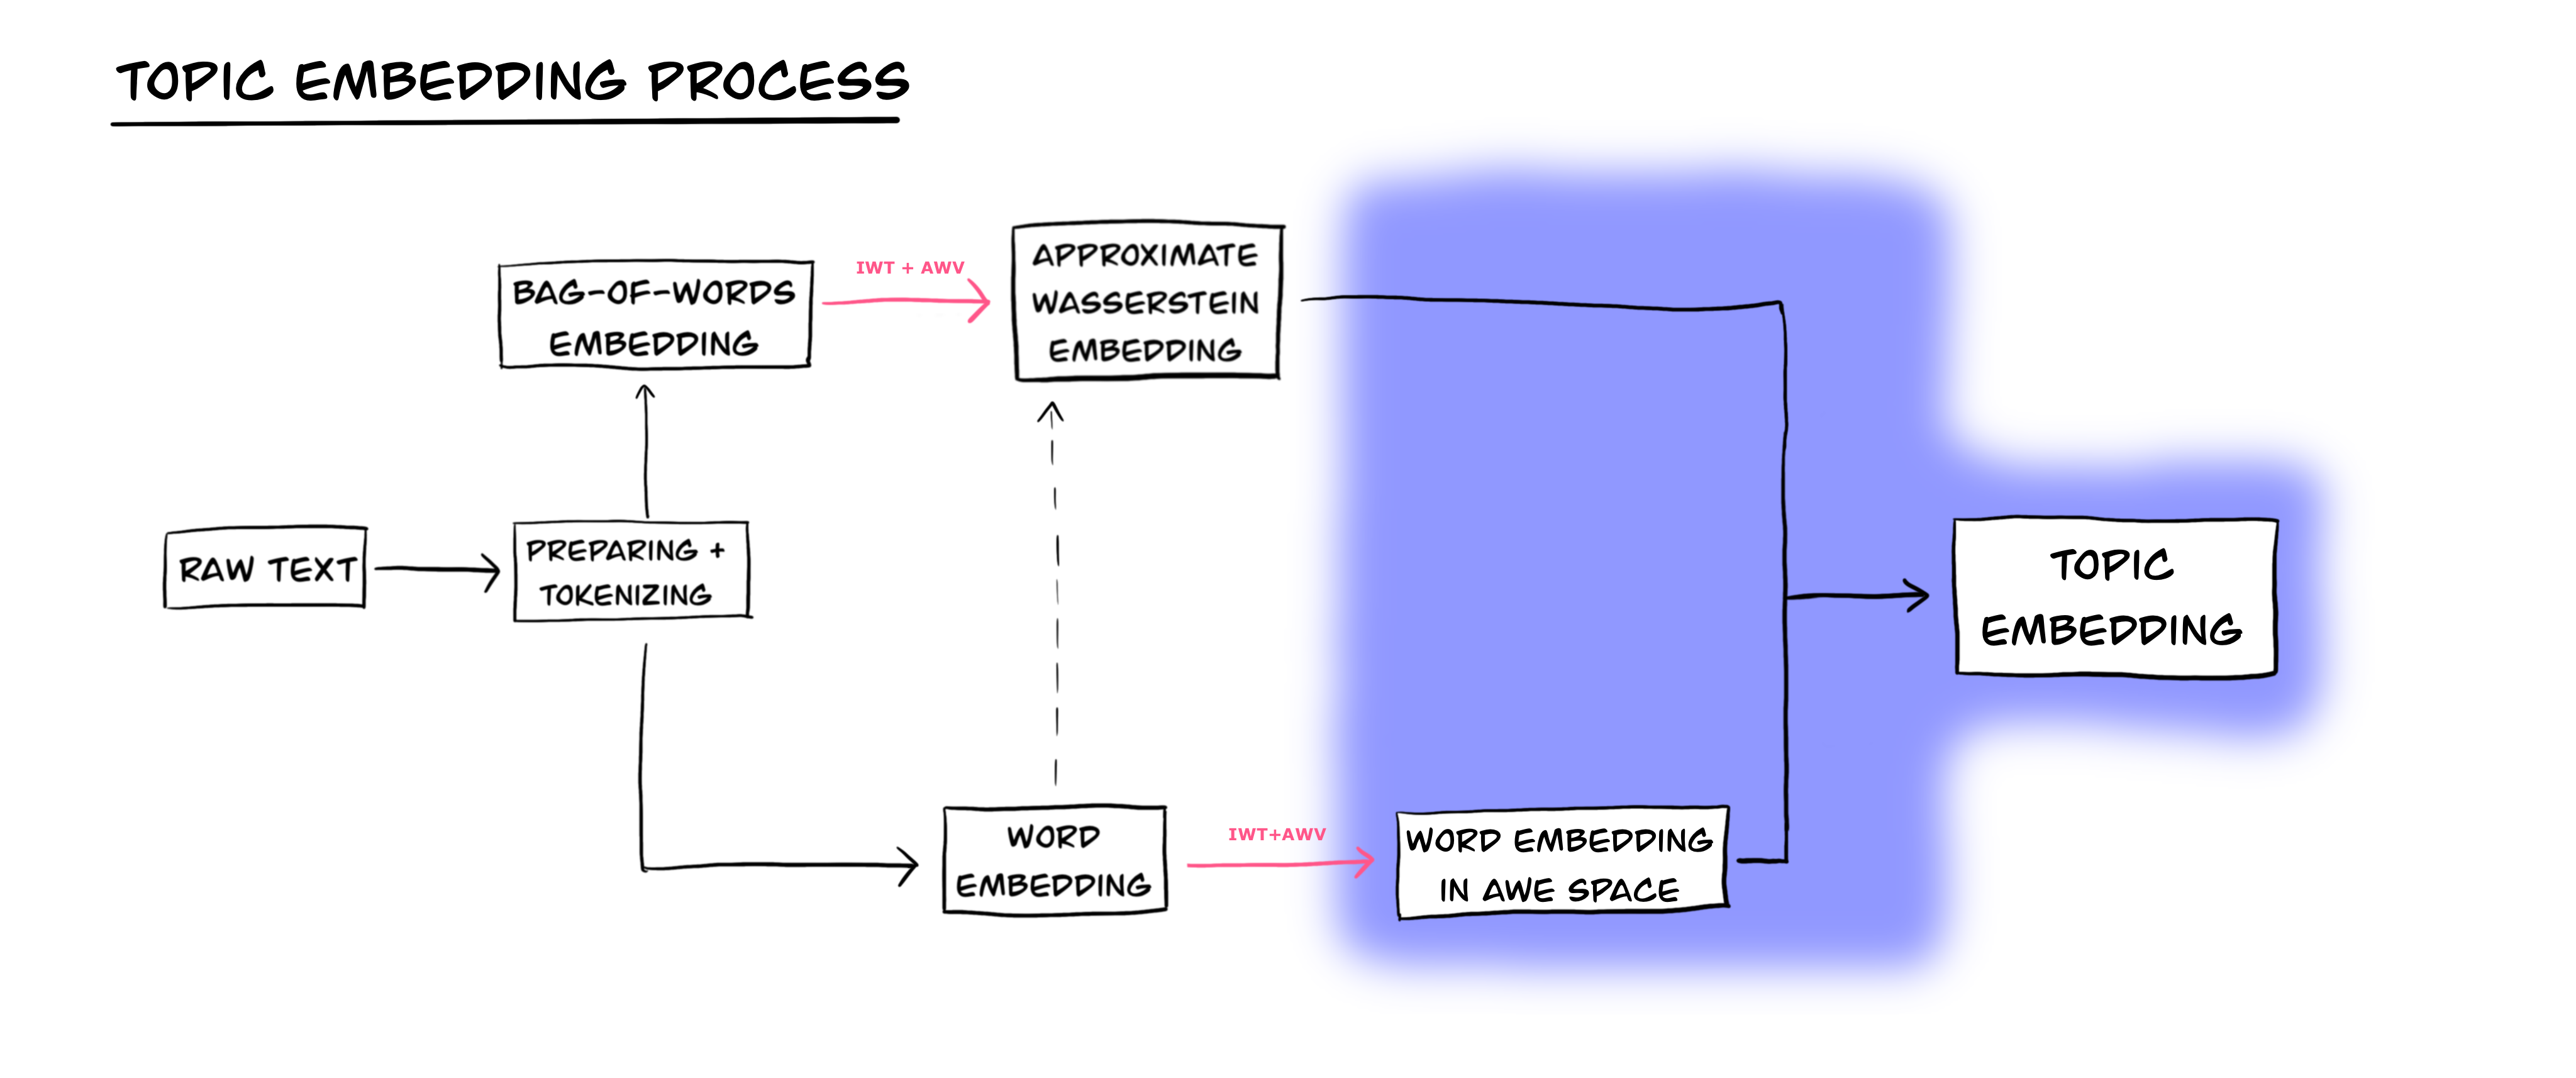
A topic embedding makes use of a joint word-document embedding, so we'll begin by doing a word embedding using the `vectorizers` library as per `02-word-embedding.ipynb`. We will use the same word embedding for both the Wasserstein embbedding and the Approximate Wasserstein embedding. We will also need this as input into the Wasserstein vectorization approaches. Creating a word embedding will also have the side benefit of giving us the vocabulary of the words from the documents via `word_vectorizer.token_label_dictionary_` that we can use for other approaches.

In [6]:
%%time
cv = sklearn.feature_extraction.text.CountVectorizer(lowercase=True)
sk_word_tokenize = cv.build_tokenizer()
sk_preprocesser = cv.build_preprocessor()
tokenize = lambda doc: sk_word_tokenize(sk_preprocesser(doc))
tokenized_news = [tokenize(doc) for doc in ds.data]

CPU times: user 1.34 s, sys: 115 ms, total: 1.46 s
Wall time: 1.64 s


In [7]:
%%time
word_vectorizer = vectorizers.TokenCooccurrenceVectorizer(
    min_document_occurrences=5,
    window_radii=10,          
    window_functions='variable',
    kernel_functions='geometric',            
    n_iter = 0,
    normalize_windows=True,
).fit(tokenized_news)
word_vectors = word_vectorizer.reduce_dimension(dimension=160, algorithm="randomized")

CPU times: user 4min 1s, sys: 8.73 s, total: 4min 9s
Wall time: 4min 42s


In [8]:
%%time
doc_matrix = vectorizers.NgramVectorizer(
    token_dictionary=word_vectorizer.token_label_dictionary_
).fit_transform(tokenized_news)

CPU times: user 15.4 s, sys: 372 ms, total: 15.8 s
Wall time: 18 s


In [9]:
%%time
info_transformer = vectorizers.transformers.InformationWeightTransformer(
    prior_strength=1e-1,
    approx_prior=False,
)
info_doc_matrix = info_transformer.fit_transform(doc_matrix)

CPU times: user 3.46 s, sys: 65.3 ms, total: 3.53 s
Wall time: 4.35 s


## Wasserstein Embedding
Here we use the Wasserstein document embedding approach described in `03-document-embeddings.ipynb`. First, we embed the documents, then we also embed the words using the trained document embedding.

In [10]:
%%time
we_vectorizer = vectorizers.WassersteinVectorizer(
    n_components=160,
    reference_size=128, 
    n_svd_iter=10,
    memory_size="4G",
    random_state=42,
)
we_doc_vectors = we_vectorizer.fit_transform(info_doc_matrix, vectors=word_vectors)
we_word_vectors = we_vectorizer.transform(
    info_transformer.transform(scipy.sparse.eye(word_vectors.shape[0])), vectors=word_vectors
)

CPU times: user 4min 17s, sys: 13.9 s, total: 4min 31s
Wall time: 2min 57s


In [11]:
we_mapper = umap.UMAP(metric="cosine", random_state=42).fit(np.vstack([we_doc_vectors, we_word_vectors]))

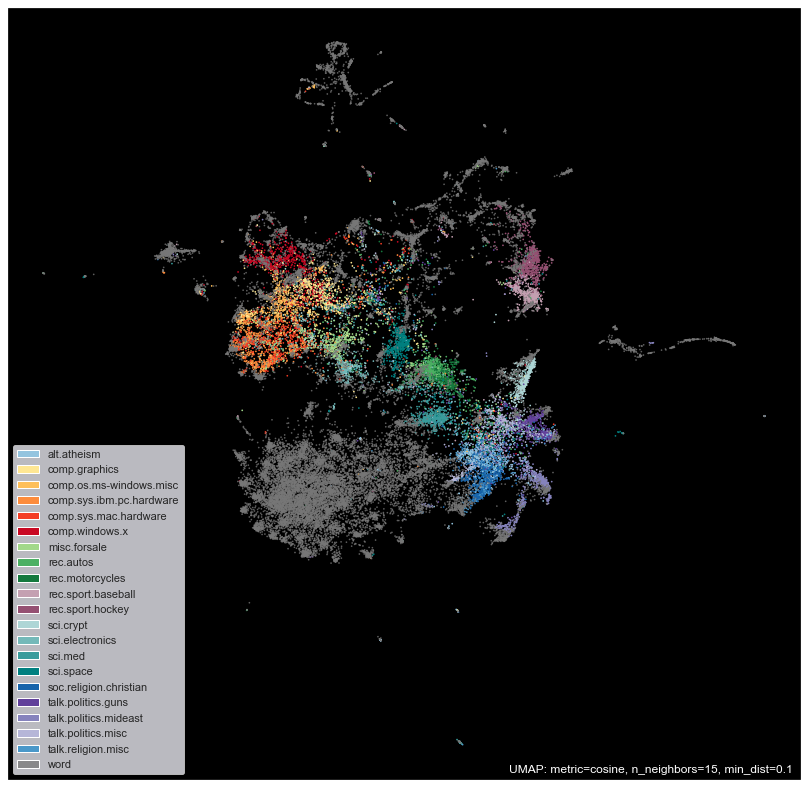

In [12]:
umap.plot.points(
    we_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in ds.target] + ["word"] * we_word_vectors.shape[0]),
    color_key=ds.COLOR_KEY,
    background="black",
    width=1024,
    height=1024,
);

## Approximate Wasserstein Embedding
Here we use the linear algebra approximation to the Wasserstein document embedding approach described in `03-document-embeddings.ipynb`. First, we embed the documents, then we also embed the words using the trained document embedding.

In [13]:
%%time
awe_vectorizer = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    random_state=42,
)
awe_doc_vectors = awe_vectorizer.fit_transform(info_doc_matrix, vectors=word_vectors)
awe_word_vectors = awe_vectorizer.transform(info_transformer.transform(scipy.sparse.eye(word_vectors.shape[0])))

CPU times: user 2.96 s, sys: 212 ms, total: 3.18 s
Wall time: 2.39 s


In [14]:
awe_mapper = umap.UMAP(metric="cosine", random_state=42).fit(np.vstack([awe_doc_vectors, awe_word_vectors]))

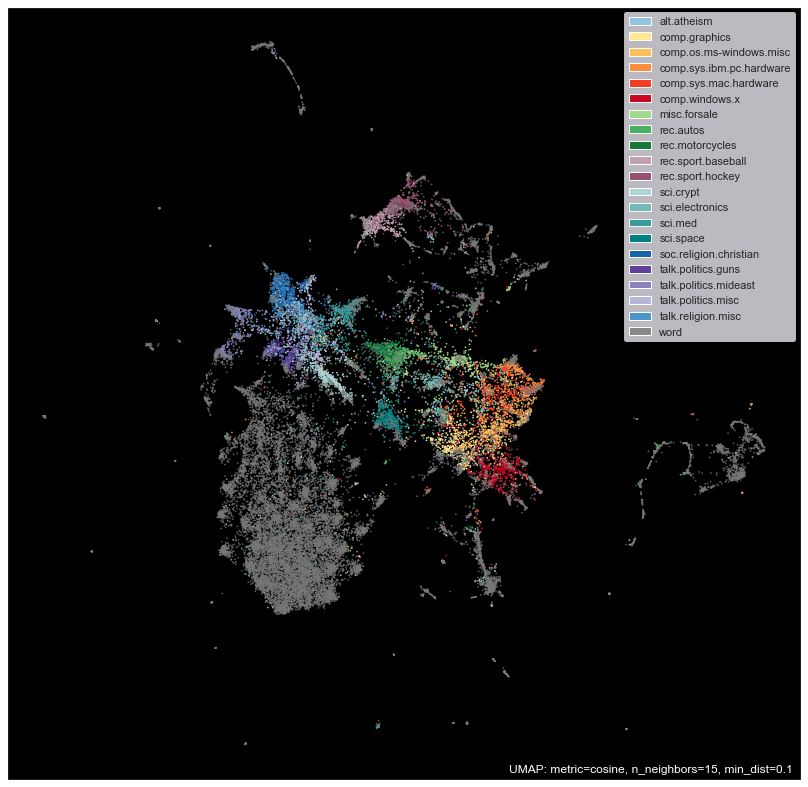

In [15]:
umap.plot.points(
    awe_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in ds.target] + ["word"] * awe_word_vectors.shape[0]),
    color_key=ds.COLOR_KEY,
    background="black",
    width=1024,
    height=1024,
);

## Universal Sentence Encoder

The Universal Sentence Encoder (USE), from Google, makes use of a Deep Averaging Network and supervised training to learn a document embedding. It is simultaneously extremely powerful and opaque. While papers describe USE's overall architecture and broad design choices, the exact details, pre-training corpus, etc. are not easily accessible or clear. However, it does a remarkable job of embedding sentences and short documents in a useful and coherent way. Here we will treat words as documents, and use the standard "out of the box" approach and load the model directly from `tensorflow_hub`.

In [16]:
use_embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [17]:
%%time
rejoined_news = [
    " ".join([word for word in doc if word in word_vectorizer.token_label_dictionary_]) 
    for doc in tokenized_news
]
use_doc_vectors = use_embed(rejoined_news).numpy()
use_word_vectors = use_embed(list(word_vectorizer.token_label_dictionary_.keys())).numpy()

CPU times: user 7min 30s, sys: 2min 32s, total: 10min 3s
Wall time: 10min 7s


In [18]:
use_mapper = umap.UMAP(metric="cosine", random_state=42).fit(np.vstack([use_doc_vectors, use_word_vectors]))

Here is the joint word-document embedding using out-of-the-box USE. Note that the words are all embedded in a separate blob away from the rest of the documents.

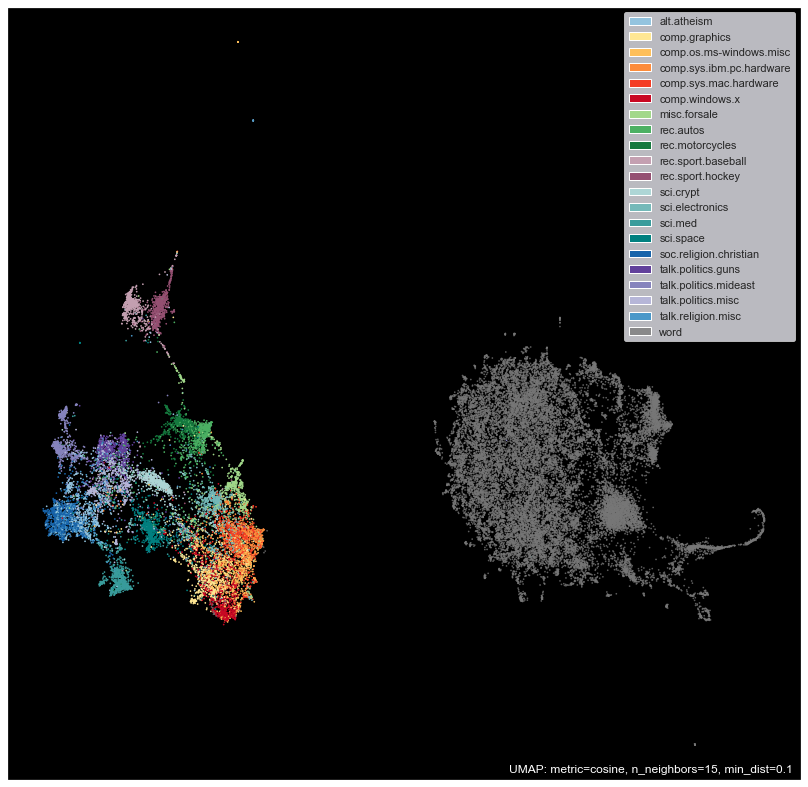

In [19]:
umap.plot.points(
    use_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in ds.target] + ["word"] * use_word_vectors.shape[0]),
    color_key=ds.COLOR_KEY,
    background="black",
    width=1024,
    height=1024,
);

## Doc2Vec

In [20]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [21]:
%%time
tagged_news = [
    TaggedDocument([word for word in doc if word in word_vectorizer.token_label_dictionary_], [i]) 
    for i, doc in enumerate(tokenized_news)
]
doc2vec_fast = Doc2Vec(
    documents=tagged_news,
    vector_size=300,
    min_count=1,
    window=15,
    sample=1e-5,
    negative=0,
    hs=1,
    epochs=20,
    dm=0,
    dbow_words=1,
    workers=4,
)

CPU times: user 28min 27s, sys: 46 s, total: 29min 13s
Wall time: 17min 6s


In [22]:
%%time
d2v_doc_vectors = doc2vec_fast.dv.get_normed_vectors()
d2v_word_vectors = doc2vec_fast.wv.get_normed_vectors()

CPU times: user 115 ms, sys: 79 ms, total: 194 ms
Wall time: 715 ms


In [23]:
d2v_mapper = umap.UMAP(metric="cosine", random_state=42).fit(np.vstack([d2v_doc_vectors, d2v_word_vectors]))

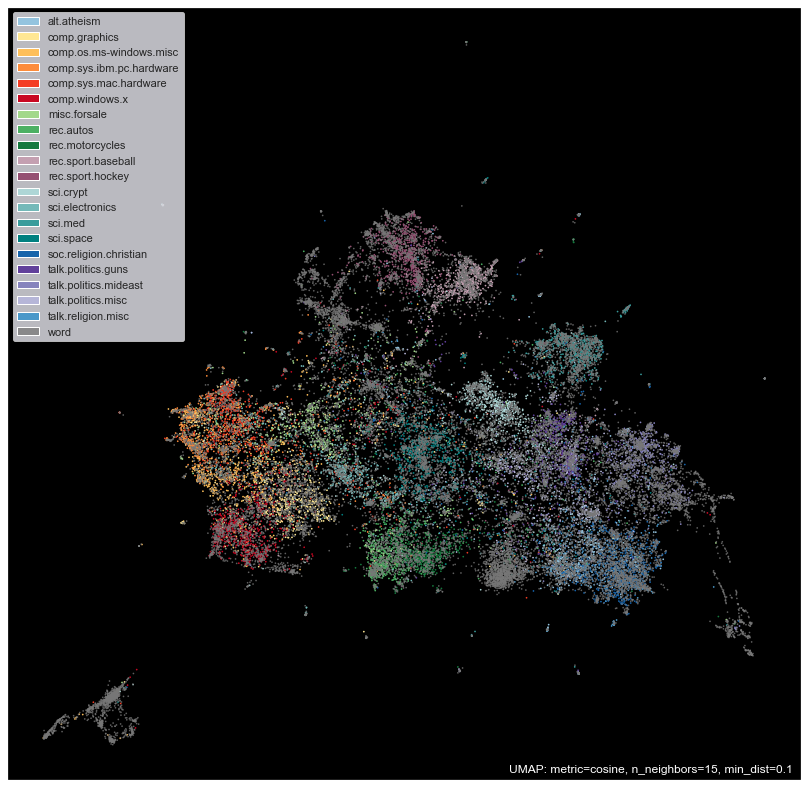

In [24]:
umap.plot.points(
    d2v_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in ds.target] + ["word"] * d2v_word_vectors.shape[0]),
    color_key=ds.COLOR_KEY,
    background="black",
    width=1024,
    height=1024,
);

# Topic Words per Newsgroup

### Universal Sentence Encoder Topic Words

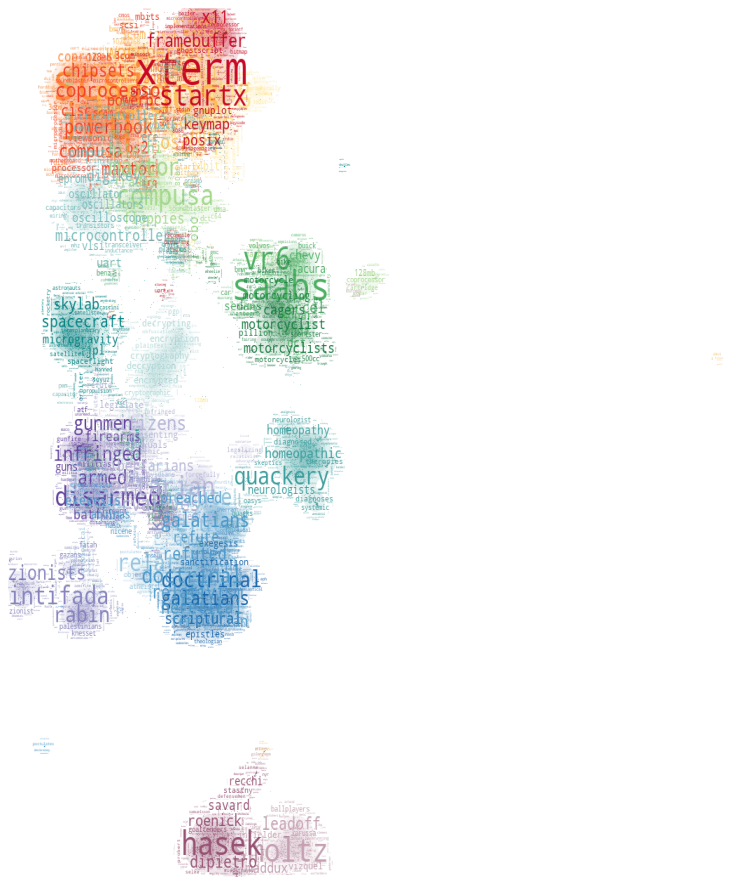

In [25]:
topic_word_by_class(
    use_doc_vectors, use_word_vectors, ds.target, 
    ds.metadata['target_names'], lambda x: word_vectorizer.token_index_dictionary_[x], ds.COLOR_KEY
)

### Doc2Vec Topic Words

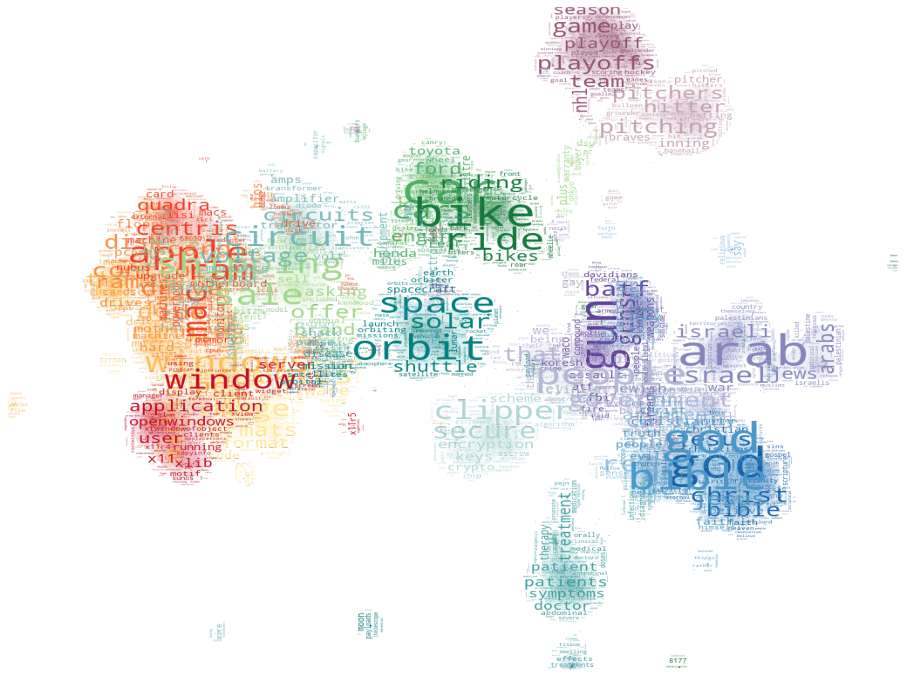

In [26]:
topic_word_by_class(
    d2v_doc_vectors, d2v_word_vectors, ds.target,
    ds.metadata['target_names'], lambda x: doc2vec_fast.wv.index_to_key[x], ds.COLOR_KEY
)

### Approximate Wasserstein Vectorized Topic Words

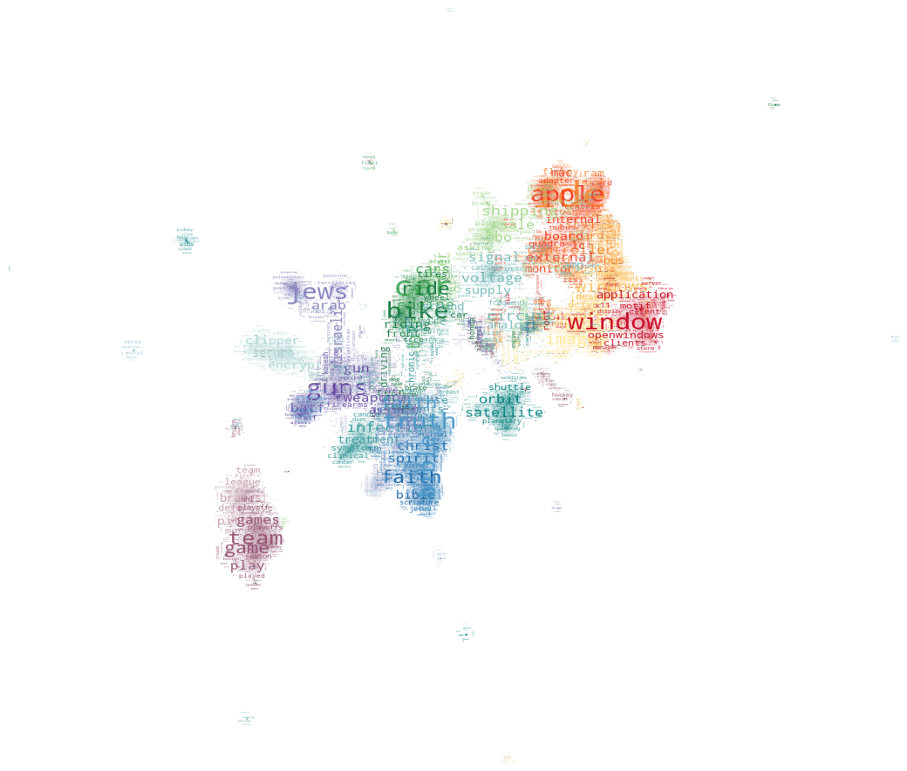

In [27]:
topic_word_by_class(
    awe_doc_vectors, awe_word_vectors, ds.target,
    ds.metadata['target_names'], lambda x: word_vectorizer.token_index_dictionary_[x], ds.COLOR_KEY
)

### Wasserstein Vectorized Topic Words

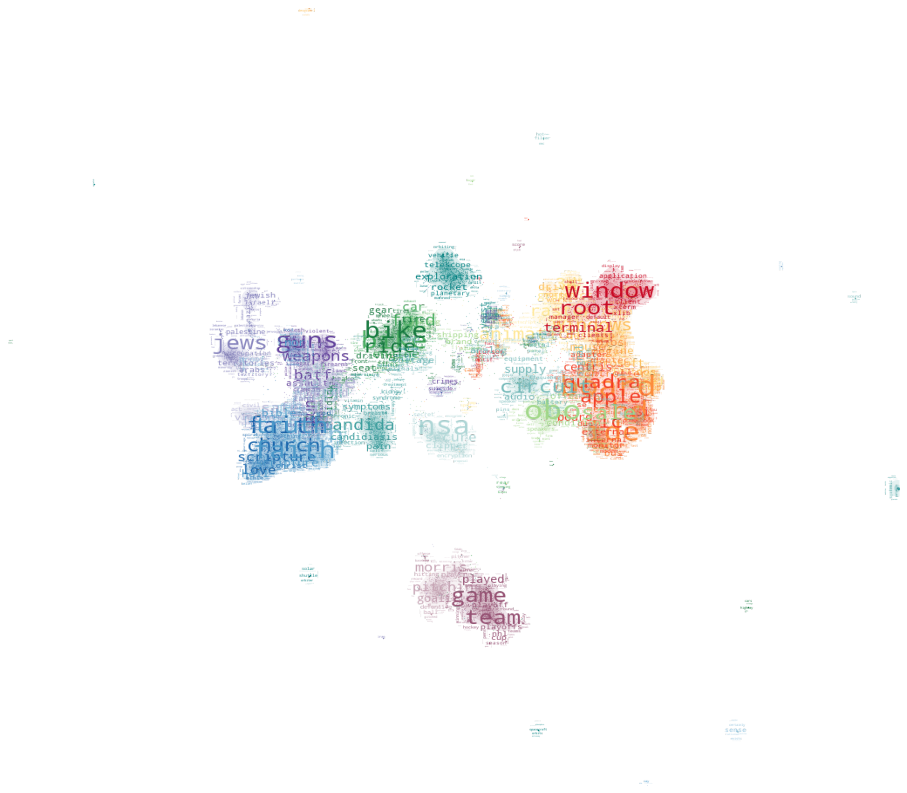

In [28]:
topic_word_by_class(
    we_doc_vectors, we_word_vectors, ds.target, 
    ds.metadata['target_names'], lambda x: word_vectorizer.token_index_dictionary_[x], ds.COLOR_KEY
)

# Topic Hierarchy via Clustering

## USE Topic Words by Cluster

CPU times: user 2min 7s, sys: 14.9 s, total: 2min 22s
Wall time: 2min 28s


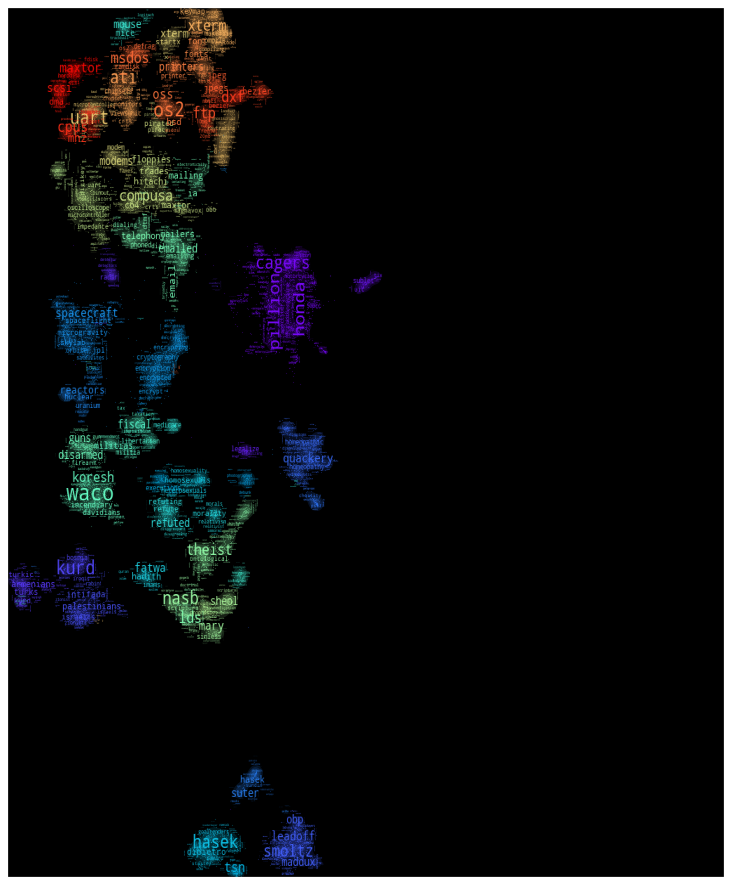

In [29]:
%%time
doc_vectors = use_doc_vectors
word_vectors = use_word_vectors

low_dim_rep = umap.UMAP(
    metric="cosine", n_components=5, min_dist=1e-4, random_state=42, n_epochs=500
).fit_transform(doc_vectors)
cluster_labels = hdbscan.HDBSCAN(min_cluster_size=25).fit_predict(low_dim_rep)
color_key = [rgb2hex(x) for x in sns.color_palette("rainbow", np.max(cluster_labels) + 1)]
topic_word_by_cluster(
    doc_vectors, 
    word_vectors, 
    cluster_labels,
    lambda x: word_vectorizer.token_index_dictionary_[x],
    color_key,
    n_neighbors=150,
    background="black",
    kernel="cosine",
);

## Doc2Vec Topic Words by Cluster

CPU times: user 2min 22s, sys: 16.7 s, total: 2min 38s
Wall time: 3min 31s


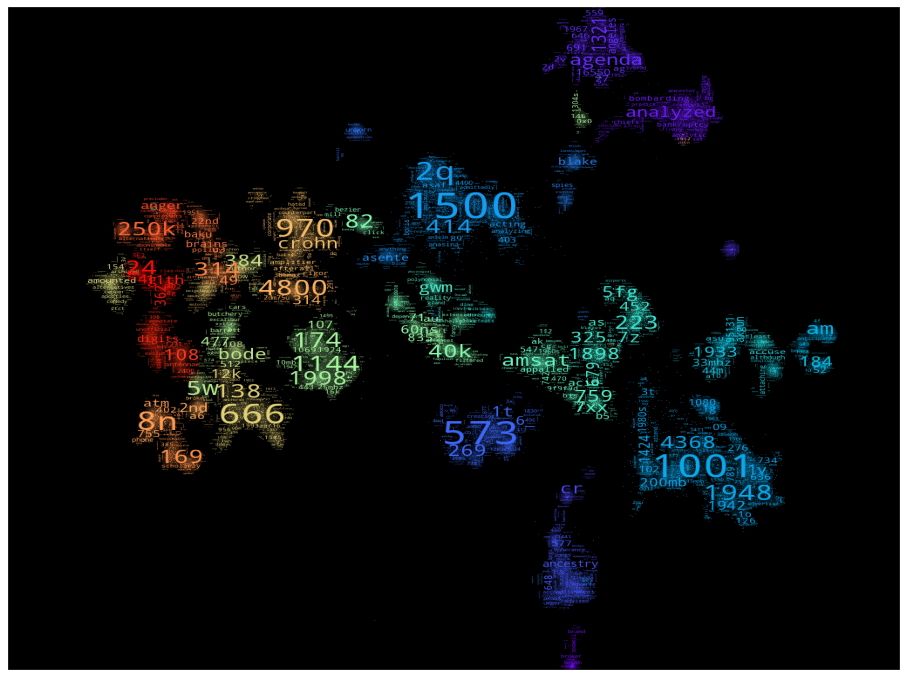

In [30]:
%%time
doc_vectors = d2v_doc_vectors
word_vectors = d2v_word_vectors

low_dim_rep = umap.UMAP(
    metric="cosine", n_components=5, min_dist=1e-4, random_state=42, n_epochs=500
).fit_transform(doc_vectors)
cluster_labels = hdbscan.HDBSCAN(min_cluster_size=25).fit_predict(low_dim_rep)
color_key = [rgb2hex(x) for x in sns.color_palette("rainbow", np.max(cluster_labels) + 1)]

topic_word_by_cluster(
    doc_vectors, 
    word_vectors, 
    cluster_labels,
    lambda x: word_vectorizer.token_index_dictionary_[x],
    color_key,
    n_neighbors=150,
    background="black",
    kernel="cosine",
);

## Approximate Wasserstein Topic Words by Cluster

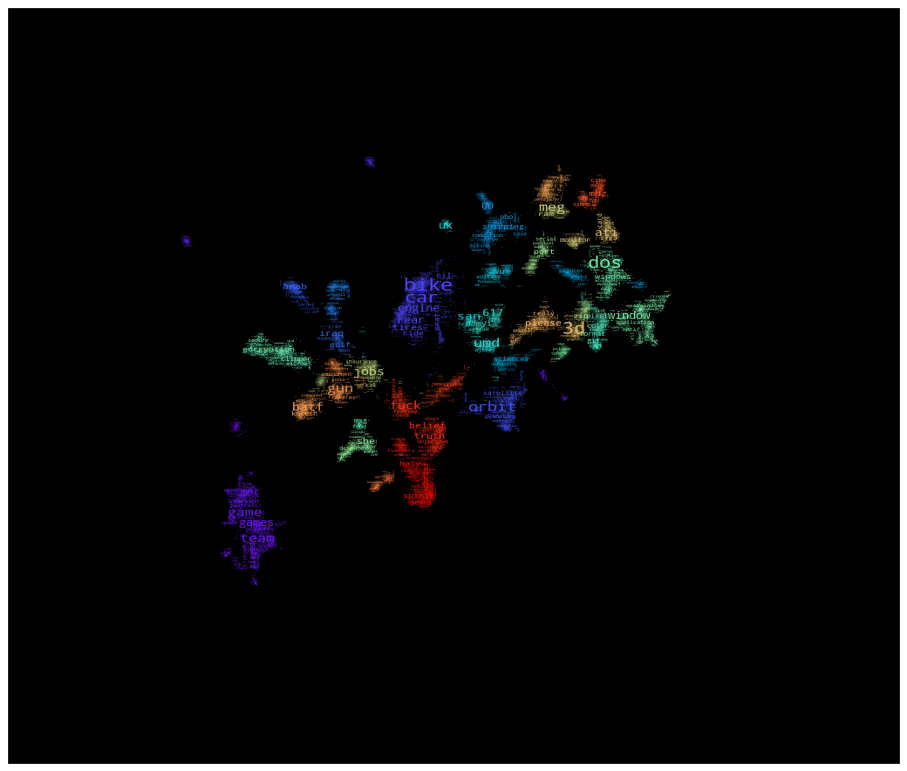

In [31]:
doc_vectors = awe_doc_vectors
word_vectors = awe_word_vectors

low_dim_rep = umap.UMAP(
    metric="cosine", n_components=5, min_dist=1e-4, random_state=42, n_epochs=500
).fit_transform(doc_vectors)
cluster_labels = hdbscan.HDBSCAN(min_cluster_size=25).fit_predict(low_dim_rep)
color_key = [rgb2hex(x) for x in sns.color_palette("rainbow", np.max(cluster_labels) + 1)]

topic_word_by_cluster(
    doc_vectors, 
    word_vectors, 
    cluster_labels,
    lambda x: word_vectorizer.token_index_dictionary_[x],
    color_key,
    n_neighbors=150,
    background="black",
    kernel="cosine",
);

## Wasserstein Topic Words by Cluster

CPU times: user 1min 47s, sys: 6.57 s, total: 1min 54s
Wall time: 2min 21s


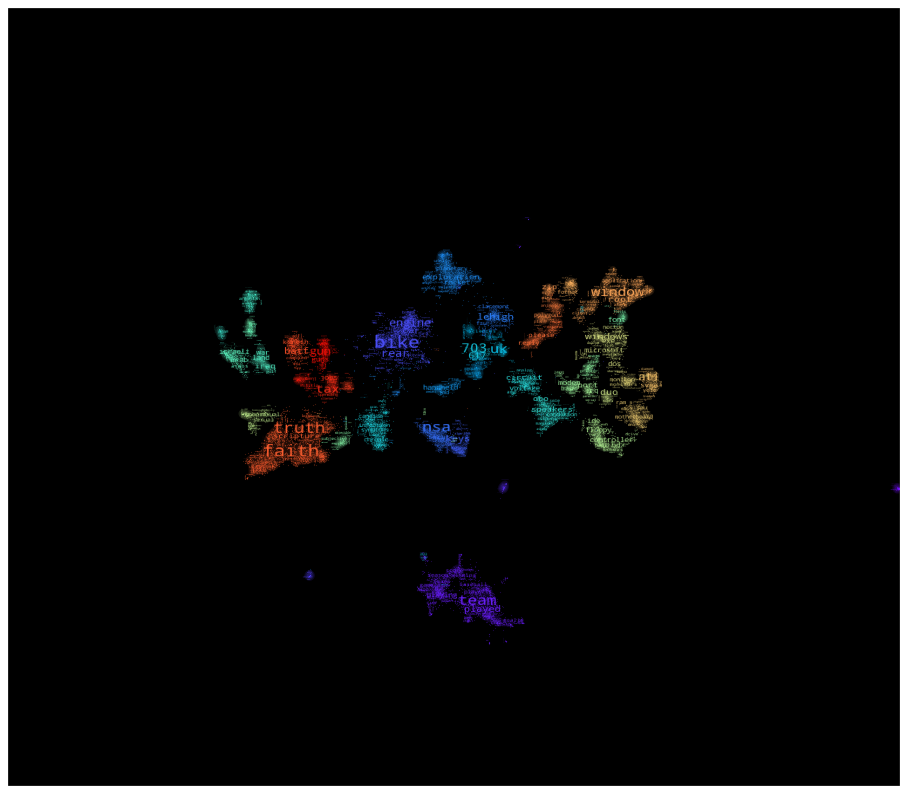

In [32]:
%%time
doc_vectors = we_doc_vectors
word_vectors = we_word_vectors

low_dim_rep = umap.UMAP(
    metric="cosine", n_components=5, min_dist=1e-4, random_state=42, n_epochs=500
).fit_transform(doc_vectors)
cluster_labels = hdbscan.HDBSCAN(min_cluster_size=25).fit_predict(low_dim_rep)
color_key = [rgb2hex(x) for x in sns.color_palette("rainbow", np.max(cluster_labels) + 1)]

topic_word_by_cluster(
    doc_vectors, 
    word_vectors, 
    cluster_labels,
    lambda x: word_vectorizer.token_index_dictionary_[x],
    color_key,
    n_neighbors=150,
    background="black",
    kernel="cosine",
);

# Topic Word Tree Exploration

## USE Topic Word Tree

In [33]:
topic_word_tree(
    use_doc_vectors, use_word_vectors, lambda x: word_vectorizer.token_index_dictionary_[x], min_dist=0.25, max_dist=1.0
)

## Doc2Vec Topic Word Tree

In [34]:
topic_word_tree(
    d2v_doc_vectors, d2v_word_vectors, lambda x: doc2vec_fast.wv.index_to_key[x], min_dist=0.1, max_dist=0.5
)

## Approximate Wasserstein Topic Word Tree

In [35]:
topic_word_tree(
    awe_doc_vectors, awe_word_vectors, lambda x: word_vectorizer.token_index_dictionary_[x], min_dist=0.0, max_dist=0.15
)

## Wasserstein Topic Word Tree

In [36]:
topic_word_tree(
    we_doc_vectors, we_word_vectors, lambda x: word_vectorizer.token_index_dictionary_[x], min_dist=0.1, max_dist=0.5
)